In [66]:
#Not all these packages are required but they are here for completeness
import importlib
import io
import matplotlib.pyplot as plt
import numpy as np
import os
import openslide
from openslide import open_slide
from pathlib import Path
import pandas as pd
from PIL import Image, ImageOps, ImageChops, ImageDraw
import SimpleITK as sitk
from skimage.color import rgb2hed
from skimage.filters import threshold_otsu
from skimage.morphology import remove_small_holes

In [2]:
# Import package 
BASE_DIR = Path().resolve()
HEMNET_DIR = BASE_DIR.parent.joinpath('HEMnet')

os.chdir(HEMNET_DIR)
from slide import *
from utils import *

In [3]:
# User Input parameters
SLIDES_PATH = Path('/gpfs1/scratch/90days/s4436005')
OUTPUT_PATH = Path('/gpfs1/scratch/90days/s4436005/img_reg/train_dataset')

ALIGNMENT_MAG = 2
TILE_MAG = 10
VERBOSE = True

#Verbose functions
if VERBOSE:
    verbose_print = lambda *args: print(*args)
    verbose_save_img = lambda img, path, img_type: img.save(path, img_type)
    verbose_save_fig = lambda fig, path, dpi=300: fig.savefig(path, dpi=dpi)
else:
    verbose_print = lambda *args: None
    verbose_save_img = lambda *args: None
    verbose_save_fig = lambda *args: None

# Find Slides
slides = []
for slide in SLIDES_PATH.glob('*.svs'):
    name = slide.name
    slides.append(name)
slides.sort()
slides

['1820_N_10545A_2_HandE.svs',
 '1820_N_10545A_4_TP53.svs',
 '1820_T_105452F_2_HandE.svs',
 '1820_T_105452F_4_TP53.svs',
 '2065_N_12752A_2_HandE.svs',
 '2065_N_12752A_4_TP53.svs',
 '2065_T_12756A_2_HandE.svs',
 '2065_T_12756A_4_TP53.svs',
 '2112_N_12341B_2_HandE.svs',
 '2112_N_12341B_4_TP53.svs',
 '2112_T_12335F_2_HandE.svs',
 '2112_T_12335F_4_TP53.svs',
 '2148_N_11397A_2_HandE.svs',
 '2148_N_11397A_4_TP53.svs',
 '2148_T_11393A_2_HandE.svs',
 '2148_T_11393A_4_TP53.svs',
 '2171_N_11521A_2_HandE.svs',
 '2171_N_11521A_4_TP53.svs',
 '2171_T_11524A_2_HandE.svs',
 '2171_T_11524A_4_TP53.svs']

In [4]:
TP53_slides = [slide for slide in slides if 'TP53' in slide]
HE_slides = [slide for slide in slides if 'HandE' in slide]
Paired_slides = list(zip(TP53_slides, HE_slides))
Paired_slides

[('1820_N_10545A_4_TP53.svs', '1820_N_10545A_2_HandE.svs'),
 ('1820_T_105452F_4_TP53.svs', '1820_T_105452F_2_HandE.svs'),
 ('2065_N_12752A_4_TP53.svs', '2065_N_12752A_2_HandE.svs'),
 ('2065_T_12756A_4_TP53.svs', '2065_T_12756A_2_HandE.svs'),
 ('2112_N_12341B_4_TP53.svs', '2112_N_12341B_2_HandE.svs'),
 ('2112_T_12335F_4_TP53.svs', '2112_T_12335F_2_HandE.svs'),
 ('2148_N_11397A_4_TP53.svs', '2148_N_11397A_2_HandE.svs'),
 ('2148_T_11393A_4_TP53.svs', '2148_T_11393A_2_HandE.svs'),
 ('2171_N_11521A_4_TP53.svs', '2171_N_11521A_2_HandE.svs'),
 ('2171_T_11524A_4_TP53.svs', '2171_T_11524A_2_HandE.svs')]

In [9]:
SLIDE_NUM = 0
PREFIX = Paired_slides[SLIDE_NUM][0][:-8]
verbose_print('Processing Slide: {0}'.format(PREFIX))
tp53_name, he_name = Paired_slides[SLIDE_NUM]
tp53_slide = open_slide(str(SLIDES_PATH.joinpath(tp53_name)))
he_slide = open_slide(str(SLIDES_PATH.joinpath(he_name)))

Processing Slide: 1820_N_10545A_4_


In [10]:
def thumbnail(img, size = (1000,1000)):
    """Converts Pillow images to a different size without modifying the original image
    """
    img_thumbnail = img.copy()
    img_thumbnail.thumbnail(size)
    return img_thumbnail

In [11]:
#Load Slides
tp53 = read_slide_at_mag(tp53_slide, ALIGNMENT_MAG)

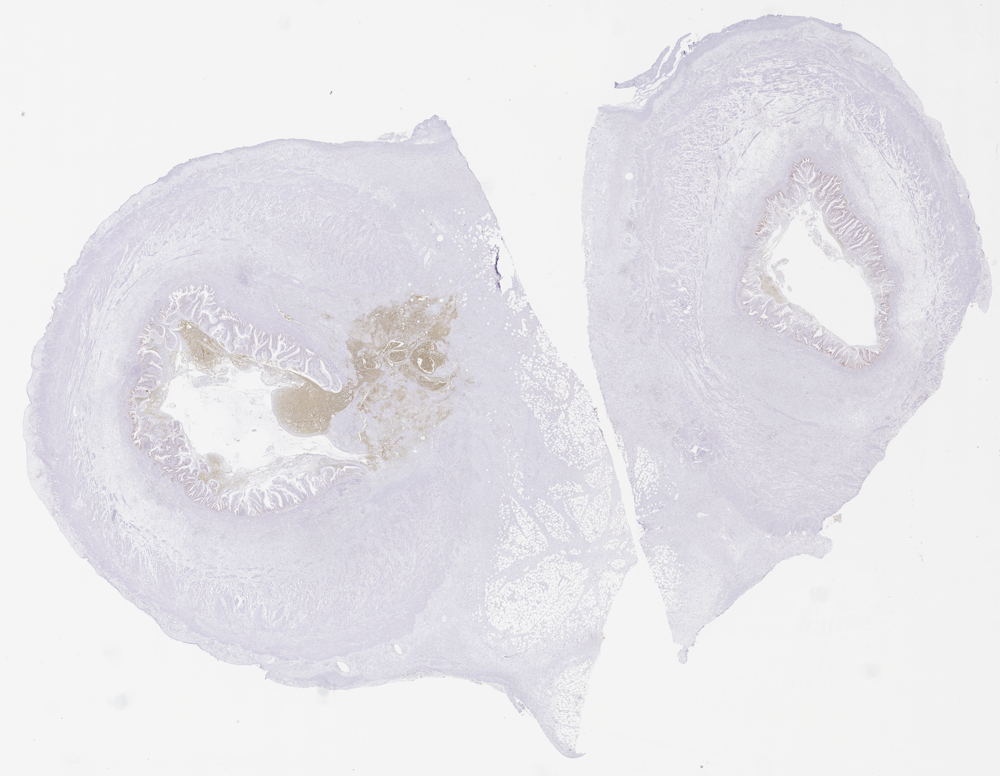

In [12]:
thumbnail(tp53)

In [17]:
#Remove backgrounds from TP53 and H&E images
tp53_filtered = filter_green(tp53)
tp53_filtered = filter_grays(tp53_filtered, tolerance = 3)

In [13]:
####################################
# Generate cancer and tissue masks #
####################################

def cancer_mask(img, tile_size, cancer_thresh):
    #Determine Dab threshold with a smaller 1000x1000 image
    downsample = max(img.size)/1000
    img_small_size = tuple([np.int(np.round(dim/downsample)) for dim in img.size])
    img_small = img.resize(img_small_size, resample = Image.BICUBIC)
    hed_small = rgb2hed(img_small)
    dab_thresh = threshold_otsu_masked(hed_small)
    mask = []
    tgen = tile_gen(img, tile_size)
    shape = next(tgen)
    for tile in tgen:
        tile = tile.convert('RGB')
        tile_hed = rgb2hed(tile)
        tile_dab = -tile_hed[:,:,2]
        binary_dab = tile_dab > dab_thresh
        if np.array(binary2gray(binary_dab)).mean() < cancer_thresh:
            mask.append(0)
        else:
            mask.append(1)
    return np.reshape(mask, shape)  

def show_mask(mask):
    return plt.imshow(np.reshape(mask, mask.shape[::-1]))

In [14]:
tile_size = 299*ALIGNMENT_MAG/TILE_MAG

In [18]:
#Generate cancer mask and tissue mask from filtered tp53 image
c_mask = cancer_mask(tp53_filtered, tile_size, 250)

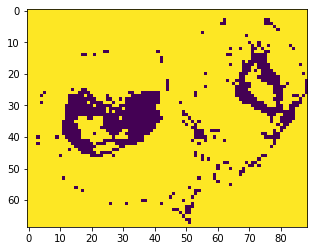

In [19]:
show_mask(c_mask)

In [55]:
hed_small = rgb2hed(thumbnail(tp53_filtered))
hed = rgb2hed(tp53_filtered)
dab_channel = -hed[:,:,2]

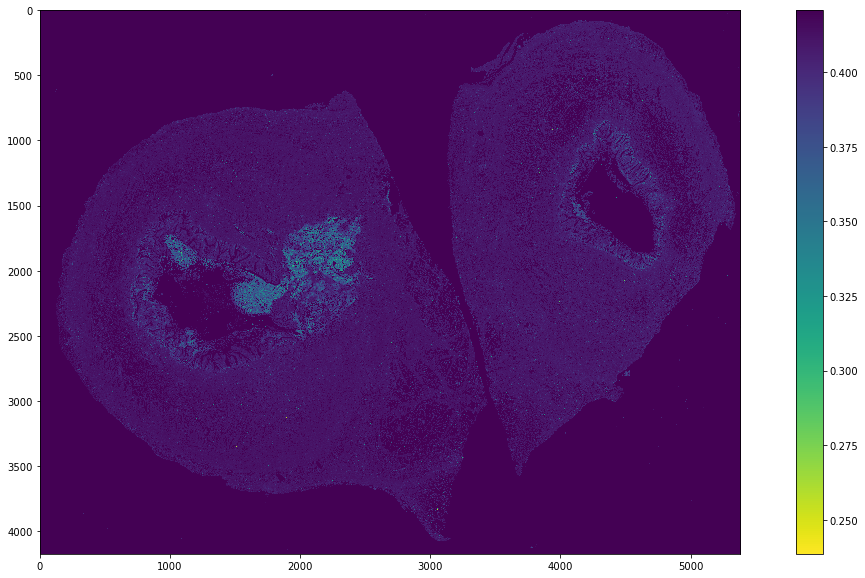

In [56]:
fig, ax = plt.subplots(figsize = (20,10))
plt.imshow(dab_channel, cmap = plt.cm.viridis_r)
plt.colorbar()

In [57]:
dab_thresh = threshold_otsu_masked(hed_small)
print(dab_thresh)

0.3941215648322949


In [58]:
dab_channel

array([[0.42079731, 0.42079731, 0.42079731, ..., 0.42079731, 0.42079731,
        0.42079731],
       [0.42079731, 0.42079731, 0.42079731, ..., 0.42079731, 0.42079731,
        0.42079731],
       [0.42079731, 0.42079731, 0.42079731, ..., 0.42079731, 0.42079731,
        0.42079731],
       ...,
       [0.42079731, 0.42079731, 0.42079731, ..., 0.42079731, 0.42079731,
        0.42079731],
       [0.42079731, 0.42079731, 0.42079731, ..., 0.42079731, 0.42079731,
        0.42079731],
       [0.42079731, 0.42079731, 0.42079731, ..., 0.42079731, 0.42079731,
        0.42079731]])

In [59]:
dab_binary = dab_channel > dab_thresh

In [60]:
dab_binary

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

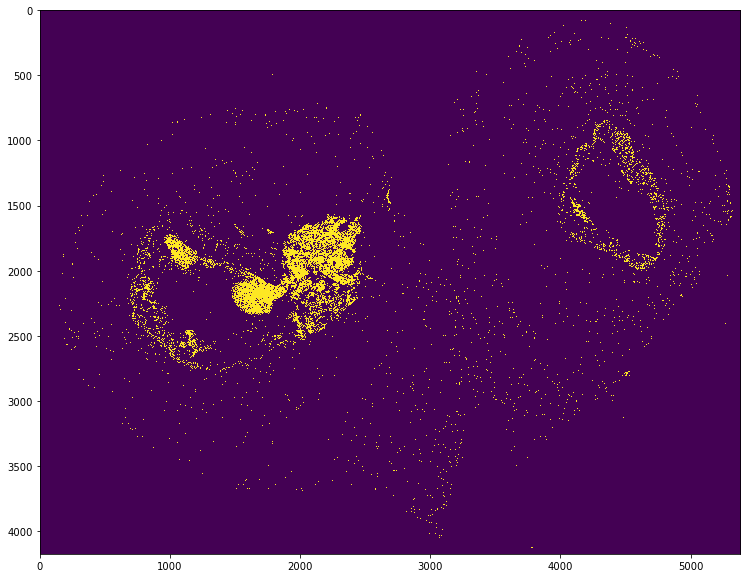

In [89]:
fig, ax = plt.subplots(figsize = (20,10))
plt.imshow(dab_binary, cmap = plt.cm.viridis_r)
#Colormap is reversed, so yellow is False

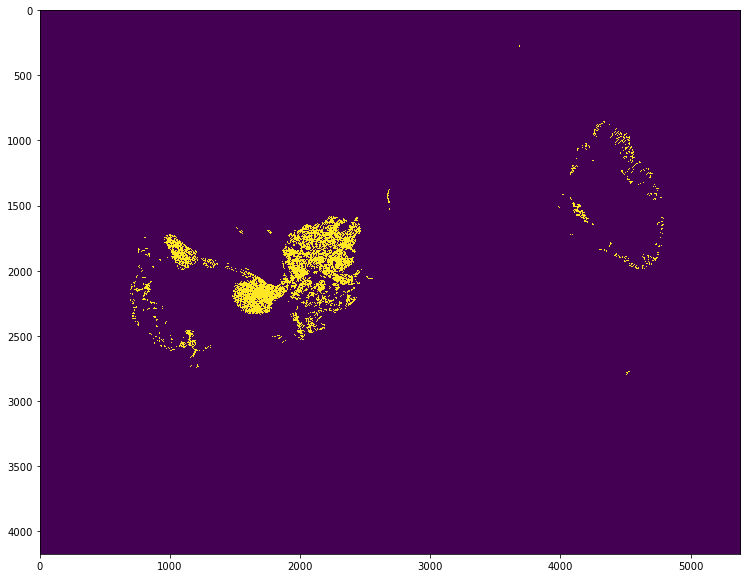

In [76]:
dab_binary_filtered = remove_small_holes(dab_binary, area_threshold = 100)
fig, ax = plt.subplots(figsize = (20,10))
plt.imshow(dab_binary_filtered, cmap = plt.cm.viridis_r)

In [78]:
from scipy import ndimage as ndi

In [82]:
ar = dab_binary
connectivity = 1

In [83]:
selem = ndi.generate_binary_structure(ar.ndim, connectivity)
ccs = np.zeros_like(ar, dtype=np.int32)
ndi.label(ar, selem, output=ccs)

17012

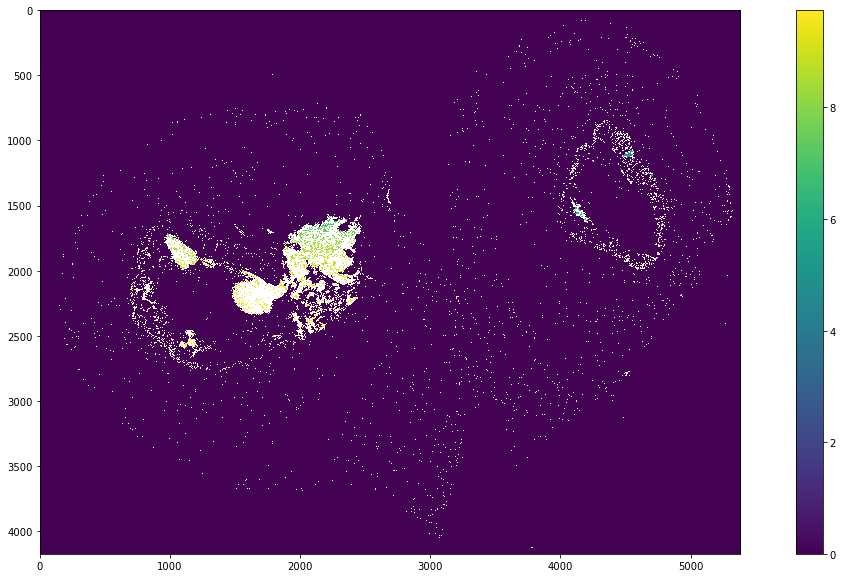

In [94]:
fig, ax = plt.subplots(figsize = (20,10))
plt.imshow(np.ma.log(ccs), cmap = plt.cm.viridis)
plt.colorbar()

In [95]:
component_sizes = np.bincount(ccs.ravel())

(array([8.660e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.775e+03, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.421e+03, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 9.350e+02, 0.000e+00, 0.000e+00,
        5.910e+02, 0.000e+00, 0.000e+00, 4.490e+02, 0.000e+00, 3.120e+02,
        0.000e+00, 2.260e+02, 0.000e+00, 2.160e+02, 1.540e+02, 0.000e+00,
        1.340e+02, 8.700e+01, 9.300e+01, 8.600e+01, 0.000e+00, 5.500e+01,
        1.080e+02, 4.200e+01, 3.300e+01, 2.500e+01, 8.100e+01, 2.300e+01,
        5.200e+01, 3.700e+01, 1.500e+01, 3.100e+01, 3.900e+01, 2.600e+01,
        1.500e+01, 2.300e+01, 2.100e+01, 1.600e+01, 1.700e+01, 1.300e+01,
        1.000e+01, 1.600e+01, 1.200e+01, 1.100e+01, 1.000e+01, 1.200e+01,
        8.000e+00, 6.000e+00, 1.000e+01, 1.000e+01, 7.000e+00, 6.000e+00,
        6.000e+00, 7.000e+00, 2.000e+00, 4.000e+00, 5.000e+00, 6.000e+00,
        3.000e+00, 4.000e+00, 1.000e+0

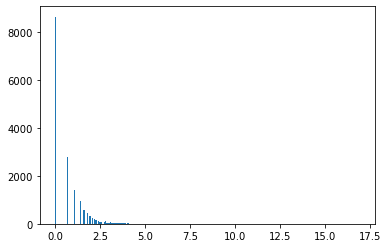

In [99]:
plt.hist(np.ma.log(component_sizes), bins = 256)